In [0]:
import numpy as np 
import pandas as pd
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
torch.cuda.is_available()

Updating fastai...
Done.


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = "/content/drive/My Drive/CrossTech/CoNhan/"
from glob import glob
images = glob(os.path.join(data_dir, '*/*.jpg'))
tot_images = len(images)
print('Total images:', tot_images)

Total images: 3355


In [0]:
tot_images = 3355
im_cnt = []
class_names = []
print('{:18s}'.format('Class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < tot_images):
        tot_images = folder_num
        folder_num = folder
        
num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))

Class             Count
------------------------
LeafBlast            779
Hispa                565
BrownSpot            523
Healthy              1488
Total number of classes: 4


In [0]:
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224), 
                                           transforms.RandomHorizontalFlip(), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]), 
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}

In [0]:
train_data = 0.8
valid_data = 0.1
test_data = 0.1

train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

num_train = len(train_data)
indices = list(range(num_train))
train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

2684 335 336
Training 2684 0.8
Validation 335 0.09985096870342772
Test 336 0.10014903129657228


In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, sampler = test_sampler)

In [0]:
classes=['On dao', 'Dom nau', 'Cay khoe', 'Sau gai']

In [0]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

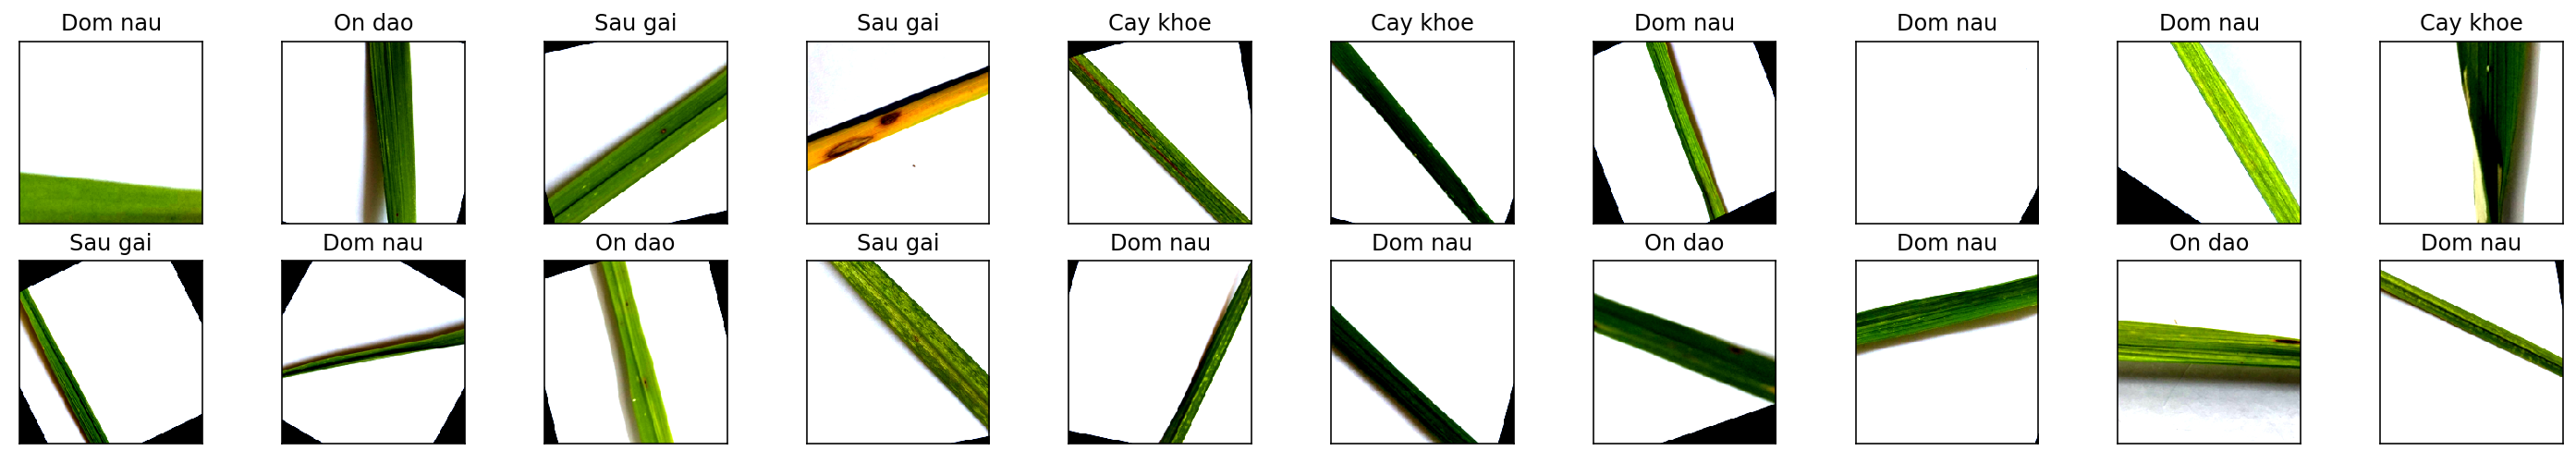

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
model_transfer = models.googlenet(pretrained=True)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

In [0]:
print(model_transfer)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
print(model_transfer.fc.in_features)
print(model_transfer.fc.out_features)

1024
1000


In [0]:
for param in model_transfer.parameters():
    param.requires_grad=True

In [0]:
n_inputs = model_transfer.fc.in_features 
last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.fc = last_layer
if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer.fc.out_features)

4


In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.inf
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            if use_cuda:
                data,target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), '/content/drive/My Drive/CrossTech/mohinh.pt')
            valid_loss_min = valid_loss
    return model

loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model_transfer.load_state_dict(torch.load('/content/drive/My Drive/CrossTech/mohinh.pt'))

Epoch: 1 	Training Loss: 1.26590 	Validation Loss: 1.49680
Validation loss decreased (inf --> 1.49680). Saving model ...
Epoch: 2 	Training Loss: 1.12020 	Validation Loss: 1.25277
Validation loss decreased (1.49680 --> 1.25277). Saving model ...
Epoch: 3 	Training Loss: 0.99248 	Validation Loss: 1.32350
Epoch: 4 	Training Loss: 0.89517 	Validation Loss: 0.90814
Validation loss decreased (1.25277 --> 0.90814). Saving model ...
Epoch: 5 	Training Loss: 0.82734 	Validation Loss: 1.09599
Epoch: 6 	Training Loss: 0.78881 	Validation Loss: 0.99934
Epoch: 7 	Training Loss: 0.76056 	Validation Loss: 1.00414
Epoch: 8 	Training Loss: 0.72172 	Validation Loss: 0.87566
Validation loss decreased (0.90814 --> 0.87566). Saving model ...
Epoch: 9 	Training Loss: 0.71346 	Validation Loss: 1.04747
Epoch: 10 	Training Loss: 0.67955 	Validation Loss: 0.85160
Validation loss decreased (0.87566 --> 0.85160). Saving model ...
Epoch: 11 	Training Loss: 0.68076 	Validation Loss: 0.89072
Epoch: 12 	Training Los

<All keys matched successfully>

In [0]:
def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.212051


Test Accuracy: 92% (310/336)
